# Image cropping function in action
## load data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from spatial_tools.image.object import ImageContainer

# path to "raw" dataset folder
BASE_PATH = "../../data"
dataset_name = "V1_Adult_Mouse_Brain"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
)
image_file = os.path.join(dataset_folder, f"{dataset_name}_image.tif")

In [2]:
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)
img = ImageContainer(image_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


adding image into object


img is an ImageContainer object, containing a .data attr which is an xarray

## crop image using crop_generator
iterates over all obs_ids, returning (obs_id, crop).
Per default, the crop has the size of the spot_diameter

In [4]:
crop_iter = img.crop_spot_generator(adata)
obs_id, crop = next(crop_iter)
print(obs_id, crop.shape)

AAACAAGTATCTCCCA-1 (3, 90, 90)


location of the obs that we have just cropped

8230 7237


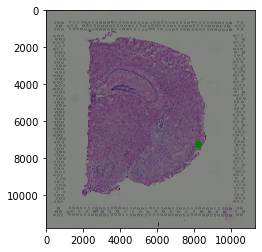

In [5]:
x , y = adata[obs_id].obsm['spatial'][0]
print(x, y)
plt.scatter(x, y, c='green')
plt.imshow(img.data['image'].transpose('y', 'x', 'channels').data)

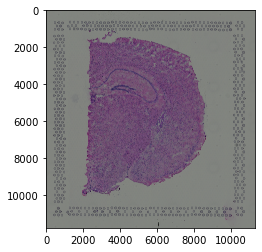

In [10]:
plt.imshow(np.transpose(img.data['image'].values, (1,2,0)))

### try different neighborhood sizes
Note that the function also works when the range is outside the image

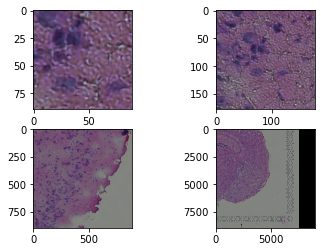

In [8]:
fig, axes = plt.subplots(2,2)
for ax, sizef in zip(axes.flat, [1,2,10,100]):
    obs_id, crop = next(img.crop_spot_generator(adata, sizef=sizef))
    ax.imshow(crop.data.transpose(1,2,0))

### try different scales
Note how the crops get smaller with smaller `scale`

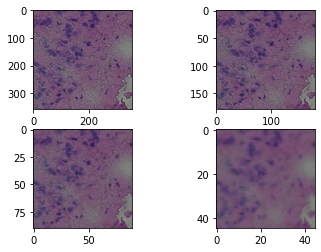

In [9]:
fig, axes = plt.subplots(2,2)
for ax, scale in zip(axes.flat, [1,0.5,0.25,0.125]):
    obs_id, crop = next(img.crop_spot_generator(adata, sizef=4, scale=scale))
    ax.imshow(crop.data.transpose(1,2,0))

## mask crops with circle
different neighborhood sizes and scales

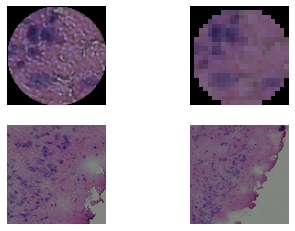

In [10]:
_, crop_1 = next(img.crop_spot_generator(adata, sizef=1, scale=1, mask_circle=True))
_, crop_2 = next(img.crop_spot_generator(adata, sizef=1, scale=0.25, mask_circle=True))
_, crop_3 = next(img.crop_spot_generator(adata, sizef=5, scale=1))
_, crop_4 = next(img.crop_spot_generator(adata, sizef=10, scale=1))

fig, axes = plt.subplots(2,2)
axes[0][0].imshow(crop_1.data.transpose(1,2,0))
axes[0][1].imshow(crop_2.data.transpose(1,2,0))
axes[1][0].imshow(crop_3.data.transpose(1,2,0))
axes[1][1].imshow(crop_4.data.transpose(1,2,0))
for ax in axes.flat:
    ax.axis('off')
#plt.savefig('crop_example.png')

## Fluorescence dataset

In [11]:
dataset_name = "V1_Adult_Mouse_Brain_Coronal_Section_2"
dataset_folder = os.path.join(
    BASE_PATH, "2020_10XFluoVisium_MouseBrain2_giovanni.palla"
)
image_file = os.path.join(dataset_folder, f"{dataset_name}_image.tif")

In [12]:
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)
img = ImageContainer(image_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


adding image into object


multi-page tiff images with 1 channel are automatically merged in one data array. Cropping will return each fluoresecent image as a channel

When cropping, we need to manually define the dtype to be uint8 to allow plotting with matplotlib

In [13]:
img.data

<xarray.Dataset>
Dimensions:   (channels: 3, x: 24240, y: 24240)
Coordinates:
  * channels  (channels) int64 1 1 1
Dimensions without coordinates: x, y
Data variables:
    image     (channels, y, x) uint16 1644 1616 1628 1628 1664 ... 0 0 0 0 0

(3, 178, 178) uint8


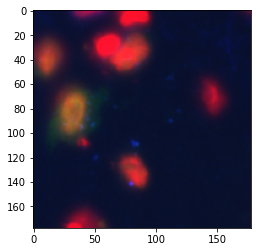

In [14]:
obs_id, crop = next(img.crop_spot_generator(adata, dtype='uint8'))
print(crop.shape, crop.dtype)
plt.imshow(crop.data.transpose(1,2,0))

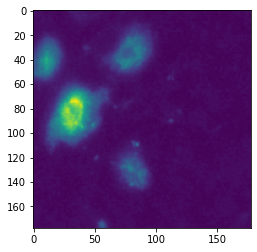

In [15]:
plt.imshow(crop[1])

In [20]:
crop[]

<xarray.DataArray (y: 178, x: 178)>
array([[18, 17, 18, ..., 17, 17, 18],
       [21, 20, 19, ..., 18, 17, 17],
       [20, 20, 19, ..., 18, 17, 17],
       ...,
       [17, 17, 16, ..., 16, 17, 17],
       [17, 17, 17, ..., 17, 17, 17],
       [17, 18, 18, ..., 17, 16, 17]], dtype=uint8)
Dimensions without coordinates: y, x